#### Notes

- TM: showing that words are semantically similiar or equal
- makes interpretation of certain topics easier

## Data loading and preprocessing

We are loading a dataset consisting of Amazon product reviews for products from the category "Electronics". We do not know what types of products are covered by these reviews and we want to uncover that by means of applying **topic modeling** (LDA) on this corpus of reviews 

In [2]:
import pandas as pd

reviews = pd.read_csv('reviews.csv', delimiter = '\t') # in our file, the values are actually TAB-separated
reviews


,label,score,content
0,POS,5.0,I upgraded from some speakers I purchased whe...
1,POS,4.0,"Pros: Great battery life Compact, but not too..."
2,POS,5.0,Okay so it was about 8:45 at night. I was com...
3,POS,5.0,This is my second Escort Passport 8500 X50. T...
4,POS,5.0,"The best headphones I ever had, good fit exce..."
...,...,...,...
195,NEG,1.0,I was really excited for these affordable spe...
196,NEG,2.0,These speakers sound great - but sometimes yo...
197,NEG,1.0,Agree with the prior reviewers. I can not get...
198,NEG,2.0,I have bought several of these. Some came in ...


### Preprocessing

We next want to preprocess our review texts to eliminate as much of the "noise" that could affect the topic modeling. We will apply common text preprocessing: 

- Tokenization: we split the texts into words/tokens
- Stopword and punctuation removal: we eliminate all tokens that are in the list of stopwords (and puncutation)
- Additionally, we remove all non-content words, i.e., all words with part-of-speech-tags that do not correspond to nouns, verbs, adjectives, ...

We will use SpaCy to perform tokenization and filtering. 
- To do that, one first needs to install spacy and download the corresponding model
- We will use the model "en_core_web_md" that contains tokenization, part-of-speech tagging and other models for English

To install spacy, run the following in command line: 
- *pip install spacy*

To download the model, run the following in command line: 
- *python -m spacy download en_core_web_md*


In [2]:
import spacy
import wordcloud
from wordcloud import STOPWORDS

# removing the repetitions if there are any, converting the list to set
stopwords = set(list(STOPWORDS) + ['.', "?", "!", ",", "(", ")", ":", ";", "\"", "'", "=", "-"])
stop_tags = ['ADV','PRON','CCONJ','PUNCT','PART','DET','SPACE', 'NUM', 'SYM']
print(stopwords)

nlp = spacy.load("en_core_web_md")

{"who's", 'when', 'each', "he'll", 'hers', 'where', 'until', 'so', 'after', 'whom', "we'd", 'because', "it's", 'are', 'not', 'against', 'all', 'or', 'own', 'between', 'having', 'them', 'like', 'could', 'doing', 'since', 'http', "they'd", 'we', '!', "you've", "i'll", 'there', 'no', 'to', 'same', 'under', 'while', 'get', 'if', 'that', '"', 'r', 'these', 'themselves', 'they', "shouldn't", "when's", "that's", 'those', 'ourselves', 'should', "why's", 'has', "didn't", 'been', ';', 'below', 'have', 'ever', "we've", "wasn't", "she'll", 'up', 'with', 'any', '.', 'can', "she'd", '?', 'about', 'at', "he'd", 'being', "couldn't", "we'll", 'again', 'am', 'just', 'otherwise', 'here', 'their', "'", "won't", 'else', "doesn't", 'its', 'yours', 'for', "aren't", 'me', 'cannot', 'itself', 'from', ',', "we're", 'it', 'your', 'k', 'why', 'and', "shan't", "i'm", "they'll", "hasn't", 'com', 'i', 'herself', 'into', 'off', 'shall', 'yourself', 'you', 'once', 'yourselves', 'is', "weren't", 'more', 'on', "here's",

In [7]:
# we're tokenizing all reviews, and from each eliminating stopwords and words with non-content POS-tags
reviews["tokens"] = reviews.content.apply(lambda x: [t.lemma_.lower() for t in nlp(x, disable=["parser", "ner"]) if (t.text.strip() != "" and (t.text.lower() not in stopwords) and t.pos_ not in stop_tags)])
#reviews: my dataframe, content: my column, apply: define a function inside that does s.th. within a column
#for t: for each text in the content
#lemma_: makes the lemma lower
#nlp: our spacy model
#disable: no need for parser and ner
#tokens without white spaces and no stopwords
#pos: part of speech tag
#["tokens"] will be added as a new token column in our pandas dataframe

In [11]:
ind = 45 #accesses row 45
reviews.iloc[ind].tokens
#print(reviews.iloc[ind].content) #access content of this row

['buy',
 'appear',
 'work',
 'work',
 'compact',
 'flourescent',
 'light',
 'fine',
 'incandescent',
 'bulb']

## Peparation for topic modeling with LDA

We will carry out topic modeling with the implementation of LDA from the popular library *gensim*. To be able to apply LDA from gensim, we first need to prepare some data structures, namely: the *dictionary* of words we will use as the vocabulary over which to carry out topic models. 

We can influence on how big the dictionary will be, via the parameters of the *filter_extremes* method:  

- by setting the minimal number of documents (reviews) in which the token has to appear to be included in the dictionary (this eliminates the most infrequent terms, unlikely to be relevant for any topic)

- by setting the maximal percentage of documents in which the token is allowed to appear (this eliminates the most frequent terms, likely to be "part of" every topic) 

In [19]:
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(reviews['tokens'])
dictionary.filter_extremes(no_below=3, no_above=0.1) #words that are infrequent: don't keep any words that appear below that amount(5)

l = list(dictionary.items())
print(l)
print(len(l))

#result: index, word

[(0, 'build'), (1, 'clean'), (2, 'crisp'), (3, 'difference'), (4, 'speaker'), (5, 'system'), (6, 'wonderful'), (7, 'worth'), (8, 'bit'), (9, 'compact'), (10, 'cons'), (11, 'consider'), (12, 'cordless'), (13, 'extra'), (14, 'include'), (15, 'keyboard'), (16, 'life'), (17, 'mouse'), (18, 'much'), (19, 'pro'), (20, 'set'), (21, 'small'), (22, 'software'), (23, 'approach'), (24, 'area'), (25, 'band'), (26, 'car'), (27, 'cross'), (28, 'dark'), (29, 'detector'), (30, 'flash'), (31, 'full'), (32, 'keep'), (33, 'leave'), (34, 'live'), (35, 'long'), (36, 'night'), (37, 'see'), (38, 'service'), (39, 'slow'), (40, 'speed'), (41, 'start'), (42, 'tell'), (43, 'thank'), (44, 'warning'), (45, 'blue'), (46, 'cause'), (47, 'charge'), (48, 'color'), (49, 'cost'), (50, 'driver'), (51, 'experience'), (52, 'give'), (53, 'hear'), (54, 'help'), (55, 'laser'), (56, 'love'), (57, 'many'), (58, 'mention'), (59, 'plenty'), (60, 'pop'), (61, 'range'), (62, 'save'), (63, 'second'), (64, 'signal'), (65, 'sure'), (6

We're next creating the corpus as a set of sparse document vectors: for this we're using the *doc2bow* function of the gensim Dictionary object: 

In [20]:
corpus = [dictionary.doc2bow(a) for a in reviews['tokens']]
corpus
#keep only tokens that appear in our dictionary
#result: documents=in [], first=id, second=frequency

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1)],
 [(21, 1),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 3),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 2),
  (40, 2),
  (41, 4),
  (42, 1),
  (43, 1),
  (44, 2)],
 [(18, 1),
  (26, 4),
  (29, 1),
  (37, 1),
  (40, 1),
  (44, 2),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 2),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 1)],
 [(68, 1), (69, 1), (70, 1)],
 [(20, 1),
  (32, 1),
  (33, 2),
  (45, 1),
  (52, 1),
  (54, 1),
  (58, 1),
  (60, 1),
  (61, 2),
  (62, 4),
  (63, 1),
  (65, 1),
  (67, 2),
  (71, 1),
  (72, 1),


## Running topic modeling (LDA)

Having prepared (1) dictionary (i.e., vocabulary) and (2) corpus (i.e., sparse document vectors over the terms of the vocabulary), we are now ready to execute/run topic modeling. 

- *gensim* contains several classes for this. The standard one is *gensim.models.ldamodel.LdaModel*. We will, however, resort to *gensim.models.LdaMulticore*, which allows a faster, multi-core training of the LDA model. Multicore means that multiple processor units (CPUs) will be used, if available, to parallelize the computation. 

*gensim.models.LdaMulticore* takes, among others, the following parameters: 
- *corpus*: the list of sparse document bag-of-word vectors (which we've built already)
- *id2word*: the mapping from vocabulary IDs to actual tokens, which is exactly what our "dictionary" contains
- *num_topics*: number of topics we would like to induce
- *iterations*: max. number of iterations through the corpus when inferring the topic distribution of a corpus
- *workers*: how many parallel threads (i.e., CPUs) to use for training the topic model  



In [17]:
import os
os.cpu_count()

12

In [21]:
from gensim.models import LdaMulticore
# alternative: gensim.models.ldamodel.LdaModel

lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=20, workers = 4)
#workers: anzahl der prozessorkerne

In [23]:
lda_model.print_topics(num_words=7)


[(0,
  '0.024*"paper" + 0.021*"setting" + 0.014*"screen" + 0.014*"mouse" + 0.012*"issue" + 0.012*"build" + 0.012*"speaker"'),
 (1,
  '0.024*"setting" + 0.022*"button" + 0.021*"router" + 0.020*"key" + 0.020*"call" + 0.019*"bass" + 0.013*"plug"'),
 (2,
  '0.022*"call" + 0.017*"base" + 0.017*"signal" + 0.017*"handset" + 0.016*"noise" + 0.015*"number" + 0.013*"bit"'),
 (3,
  '0.021*"return" + 0.016*"transmitter" + 0.016*"second" + 0.016*"bad" + 0.014*"card" + 0.013*"targus" + 0.012*"line"'),
 (4,
  '0.020*"song" + 0.020*"player" + 0.015*"mp3" + 0.012*"photo" + 0.010*"recorder" + 0.009*"excellent" + 0.009*"pick"'),
 (5,
  '0.033*"mouse" + 0.019*"feature" + 0.013*"cordless" + 0.012*"pad" + 0.011*"old" + 0.011*"fm" + 0.010*"mac"'),
 (6,
  '0.016*"happen" + 0.015*"may" + 0.013*"base" + 0.013*"set" + 0.013*"nice" + 0.012*"bad" + 0.012*"keep"'),
 (7,
  '0.025*"antenna" + 0.019*"gps" + 0.019*"poor" + 0.018*"support" + 0.016*"service" + 0.016*"palm" + 0.015*"pay"'),
 (8,
  '0.034*"mouse" + 0.030*"

How are topics represented in documents? Or, put differently, which documents belong to which topics?
- This information is stored in our *lda_model* object after training
- We can access the corpus with lda_model[corpus] and then index that list for the document we're interested in

In [27]:
ind = 48 #choose document 48 and compare it how much it fits
print(lda_model[corpus][ind]) #how much percent fits to the model
reviews["content"][ind]

[(2, 0.95249873)]


' My favorite thing about this phone is that the caller ID captures 11 digit numbers (1-xxx-xxx-xxxx) which are then very easy to store into the phone book and call. My old phone only captured 10 digits (xxx-xxx-xxxx) which meant I had to reenter everything manually because of course you have to dial a 1 first. This new phone also allows me to toggle between 11 digits and 7 digits on the same number. I put together my phone book just by capturing calls as they came in. Very handy. As far as being a phone, it does everything well and after a couple of months I am still as happy as could be with it'

## Evaluating topics

- Question #1: How good are the topics we induced? 
- Question #2: We define the number of topics in advance. What is the optimal number of topics? Optimal w.r.t. what criteria?

One widely adopted way to evaluate topic models is with various coherence measures: these quantify (in various ways) the semantic similarity / lexical association between the most prominent words of each topic. If the words that have the highest weight in each topic are not semantically similar/associated, then the topic is not coherent. 

There is a number of coherence measures already implemented in *gensim* in the class *gensim.modelsCoherenceModel*. We will use some of those to quantify the coherence of the topics we induced. 
 

In [29]:
# We will execute topic modeling 20 times, each time with the different number of topics
#if words more often appear than expected
max_topics = 15
models = []

for i in range(max_topics):
    print("Training LDA with " + str(i+1) + " topics.")
    
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i+1, workers = 4, random_state=100)
    models.append(lda_model)
          
    print("Done.")    

Training LDA with 1 topics.
Done.
Training LDA with 2 topics.
Done.
Training LDA with 3 topics.
Done.
Training LDA with 4 topics.
Done.
Training LDA with 5 topics.
Done.
Training LDA with 6 topics.
Done.
Training LDA with 7 topics.
Done.
Training LDA with 8 topics.
Done.
Training LDA with 9 topics.
Done.
Training LDA with 10 topics.
Done.
Training LDA with 11 topics.
Done.
Training LDA with 12 topics.
Done.
Training LDA with 13 topics.
Done.
Training LDA with 14 topics.
Done.
Training LDA with 15 topics.
Done.


In [30]:
models[6].print_topics(num_words = 5)

[(0,
  '0.016*"mouse" + 0.013*"set" + 0.013*"call" + 0.012*"turn" + 0.011*"bulb"'),
 (1,
  '0.017*"ipod" + 0.016*"card" + 0.015*"player" + 0.015*"headset" + 0.012*"mp3"'),
 (2,
  '0.017*"handset" + 0.013*"call" + 0.011*"gps" + 0.011*"base" + 0.011*"tv"'),
 (3,
  '0.019*"card" + 0.015*"ipod" + 0.013*"printer" + 0.012*"put" + 0.012*"setting"'),
 (4,
  '0.021*"case" + 0.011*"service" + 0.010*"lock" + 0.010*"start" + 0.010*"targus"'),
 (5,
  '0.016*"service" + 0.012*"player" + 0.012*"support" + 0.012*"printer" + 0.008*"video"'),
 (6,
  '0.024*"mouse" + 0.022*"button" + 0.016*"software" + 0.011*"keep" + 0.010*"computer"')]

In [32]:
from gensim.models import CoherenceModel

coherence_measure = "c_uci" # 'u_mass', 'c_v', 'c_uci', 'c_npmi' #play with different measures
scores = []

for i in range(len(models)): #goes through our whole number of topics
    print("Computing coherence for the LDA model with " + str(i+1) + " topics.")
    cm = CoherenceModel(model=models[i], corpus=corpus, texts = reviews["tokens"], dictionary=dictionary, coherence=coherence_measure)
    score = cm.get_coherence() 
    print(score) #for u_mass: the closer the score the better (see documentation of the coherence for further information)
    scores.append(score)
    print("Done.")
    

Computing coherence for the LDA model with 1 topics.
-10.321304386811377
Done.
Computing coherence for the LDA model with 2 topics.
-9.948956450861466
Done.
Computing coherence for the LDA model with 3 topics.
-10.298126446993406
Done.
Computing coherence for the LDA model with 4 topics.
-10.587144745981902
Done.
Computing coherence for the LDA model with 5 topics.
-10.613323374433756
Done.
Computing coherence for the LDA model with 6 topics.
-10.735727237534306
Done.
Computing coherence for the LDA model with 7 topics.
-10.573723043968233
Done.
Computing coherence for the LDA model with 8 topics.
-10.760628714438283
Done.
Computing coherence for the LDA model with 9 topics.
-11.01474806589013
Done.
Computing coherence for the LDA model with 10 topics.
-11.26122583594968
Done.
Computing coherence for the LDA model with 11 topics.
-10.89886310972748
Done.
Computing coherence for the LDA model with 12 topics.
-11.70820064911232
Done.
Computing coherence for the LDA model with 13 topics.


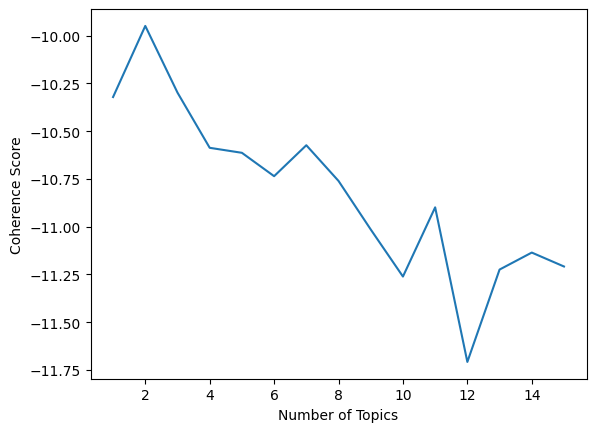

In [33]:
import matplotlib.pyplot as plt

num_topics = [i+1 for i in range(len(scores))]
                                
_=plt.plot(num_topics, scores)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [34]:
# according to the c_v measure, 16 topics looks like a good choice
# let's see what those topics look like

num_tops = 15
models[num_tops - 1].print_topics(num_words = 5)

[(0,
  '0.016*"mouse" + 0.015*"set" + 0.015*"bulb" + 0.014*"hope" + 0.013*"call"'),
 (1,
  '0.019*"player" + 0.019*"headset" + 0.017*"song" + 0.015*"mp3" + 0.012*"turn"'),
 (2,
  '0.021*"base" + 0.018*"handset" + 0.014*"useless" + 0.012*"send" + 0.012*"call"'),
 (3,
  '0.027*"card" + 0.025*"printer" + 0.023*"photo" + 0.015*"canon" + 0.013*"ipod"'),
 (4,
  '0.029*"call" + 0.023*"lock" + 0.016*"message" + 0.016*"mine" + 0.016*"bulb"'),
 (5,
  '0.018*"service" + 0.017*"support" + 0.013*"video" + 0.012*"mouse" + 0.012*"vonage"'),
 (6,
  '0.029*"mouse" + 0.029*"button" + 0.021*"software" + 0.015*"keep" + 0.014*"pad"'),
 (7,
  '0.029*"ipod" + 0.020*"player" + 0.019*"apple" + 0.016*"mp3" + 0.016*"feature"'),
 (8,
  '0.018*"player" + 0.015*"include" + 0.014*"printer" + 0.014*"wheel" + 0.012*"song"'),
 (9,
  '0.022*"card" + 0.019*"tv" + 0.014*"handset" + 0.013*"antenna" + 0.011*"plug"'),
 (10,
  '0.020*"setting" + 0.014*"headset" + 0.013*"router" + 0.011*"canon" + 0.010*"mouse"'),
 (11,
  '0.02

## Topic Visualization

There is a special library, *pyLDAvis*, that we can use to visualize topic models induced with *gensim* (among other). All you need to do is: 

- import the pyLDAvis package
- allow it to run inside the Jupyter notebook
- instantiate/prepare the display object, feeding the LDA model as an argument
- call the display function

In [36]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook

In [37]:
lda_display = pyLDAvis.gensim_models.prepare(models[num_tops - 1], corpus, dictionary)
pyLDAvis.display(lda_display)